# Used to distill Velocities from drone Video data

In [6]:
import matplotlib 
matplotlib.use("Agg") 
import matplotlib.pyplot as plt
import sys
import argparse
import cv2

from openpiv import tools, process, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import imageio

import pandas as pd
import xarray as xr

import openpiv.tools
import openpiv.process 
import openpiv.scaling 
import openpiv.validation 
import openpiv.filters
import glob

import pandas as pd
import xarray as xr
import fsspec

import urllib
import urllib.request
from urllib.request import urlopen

import IPython ## 
from IPython import display
display.set_matplotlib_formats('retina')
from IPython.display import YouTubeVideo
import glob
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
%matplotlib inline  


### Define Function to extract Velocity Fields from Video Data

In [7]:
def Vid2PIV(fileIn, fileOut, AGL, FOV):
    
    """ Vid2PIV is a function used to convert still hovering drone footage to scaled velocity fields which can be analyzed in xarray. 
    It is an implementation of particle image velocimetry based on OpenPIV.
    
    INPUTS: 
   
    fileIn: Local path to video (.mov or .mp4 file format)
    fileOut: Name you would like to save your velocity .nc file
    AGL: Above ground level (Altitude of drone) in meters
    FOV: Field of View of sensor in degrees
    
    OUTPUTS: A saved xarray dataset in .nc file format
    
    """
    
    
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success, frame_a = vidcap.read()
    

    
    tf =  int(np.floor(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)/ vidcap.get(cv2.CAP_PROP_FPS))) #to get number of seconds in video final time
    print('Number of sec in video:', tf)
    x, y = process.get_coordinates( image_size=frame_a.shape, window_size=64, overlap=32 )
    
    
    dfi = xr.Dataset(
        data_vars={'u': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1))),
                   'v': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1))),
                   's': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1)))},
        coords={'x': x[0,:],'y': y[:,0],'time':np.arange(tf-1)})
    
    
    frame_a = frame_a[:,:,2]*0.2989 + frame_a[:,:,1]*0.5870 + 0.1140*frame_a[:,:,0] #convert to greyscle
    frame_a = (frame_a).astype(np.int32)
    
    
    #Calulate GSD for video
    AGL = AGL #meters  
    FOV = np.deg2rad(FOV) #degrees
    Width  = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width` in pixels
    Height = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height` in pixels
    Aspect = Height/Width    # CONFIRM THIS IS CORRECT
    D =   2 * AGL *np.tan(FOV/2) #diagnol of image
    A = (D) / np.sqrt(1 + Aspect**2)
    B = Aspect * D / np.sqrt(1 + Aspect**2)
    print('Image Footprint:',A, 'm x', B, 'm y')
    GSDx = A/ Width #meters per pixel
    GSDy = B/ Height #meters per pixel
    

    
    
    for count in np.arange(tf-1):
        
        vidcap.set(cv2.CAP_PROP_POS_MSEC,((count+1)*1000))    # added this line (1000 is 1 second, 100 is .1 sec) 
        success,frame_b = vidcap.read()
        print ('Read a new frame', "%03d" % (count+1), success)  #take it out
      
      #PIV
               
        frame_b = frame_b[:,:,2]*0.2989 + frame_b[:,:,1]*0.5870 + 0.1140*frame_b[:,:,0]
        frame_b = (frame_b).astype(np.int32)
       

        u, v, sig2noise = process.extended_search_area_piv( frame_a, frame_b, \
            window_size=64, overlap=32, dt=1, search_area_size=128, sig2noise_method='peak2peak' )
        #x, y = process.get_coordinates( image_size=frame_a.shape, window_size=64, overlap=32 )
        u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.2 ) #why does it not work at night?
        u, v, mask = validation.global_val( u, v, (-1000, 2000), (-1000, 1000) )
        u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
        #x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1)
    
        
        dfi.u[:,:,count] = np.transpose(u)
        dfi.v[:,:,count] = np.transpose(v)
    
    
    # additional processing
    #Sensor and Drone Measurments 
        dfi.u[:,:,count] = dfi.u[:,:,count] *GSDx 
        dfi.v[:,:,count] = dfi.v[:,:,count]*-1 * GSDy # the negative is to make the downstream velocity positive
        dfi.s[:,:,count] = np.sqrt(dfi.u[:,:,count]**2+dfi.v[:,:,count]**2) 
        

        
        frame_a = frame_b
    
    #Spatial Calculation (can possibly take this out of the loop?)
    dfi['x'] = dfi.x*GSDx 
    dfi['y']= dfi.y*GSDy 
    
    dfi.to_netcdf(pathOut)
    
    return(dfi)

In [10]:
import exiftool#pathIn = '/Volumes/KLERZ_Vel/Sites/Site4/DJI_0001_20180801_VelPt4_1806.MOV'
pathIn = 'Site6_2sec.mov'
with exiftool.ExifTool('/Users/Jasper/pyexiftool/exiftool.py') as et:
    metadata = et.get_metadata_batch(pathIn)

## Run velocimetry on video
### Define path of video, saved file name and flight parameters

In [8]:
ft2m = 0.3048
AGL_ft2m = ft2m * 1000 #input ft, get out meters
print(AGL_ft2m)



304.8


In [32]:
path = '/Volumes/LaCie/Velocimetry/Site4/0712'

csv_files = glob.glob(os.path.join(path, "*.MOV"))
csv_files

['/Volumes/LaCie/Velocimetry/Site4/0712/DJI_0004_Vel_Pt4_1500_ft.MOV',
 '/Volumes/LaCie/Velocimetry/Site4/0712/0712_19_47DJI_0002_Vel_Pt4_1000_ft.MOV',
 '/Volumes/LaCie/Velocimetry/Site4/0712/0712_19_48_DJI_0003_Vel_Pt4_1300_ft.MOV']

In [29]:
pathIn = '/Volumes/LaCie/Velocimetry/Site4/0712/0712_19_47DJI_0002_Vel_Pt4_1000_ft.MOV'
pathOut= [pathIn[:-3]+ 'nc'] #change to saved file


AGL = 304.8  #Above ground level (meters) 
FOV =78.8     #Field of view (degrees) for mavic 4

#Thresh6 = Vid2PIV(pathIn, pathOut, AGL, FOV)


In [28]:
pathOut= [pathIn[:-3] + 'nc'] #change to saved file
pathOut


['/Volumes/LaCie/Velocimetry/Site4/0712/0712_19_47DJI_0002_Vel_Pt4_1000_ft.nc']

### Inspect How it looks

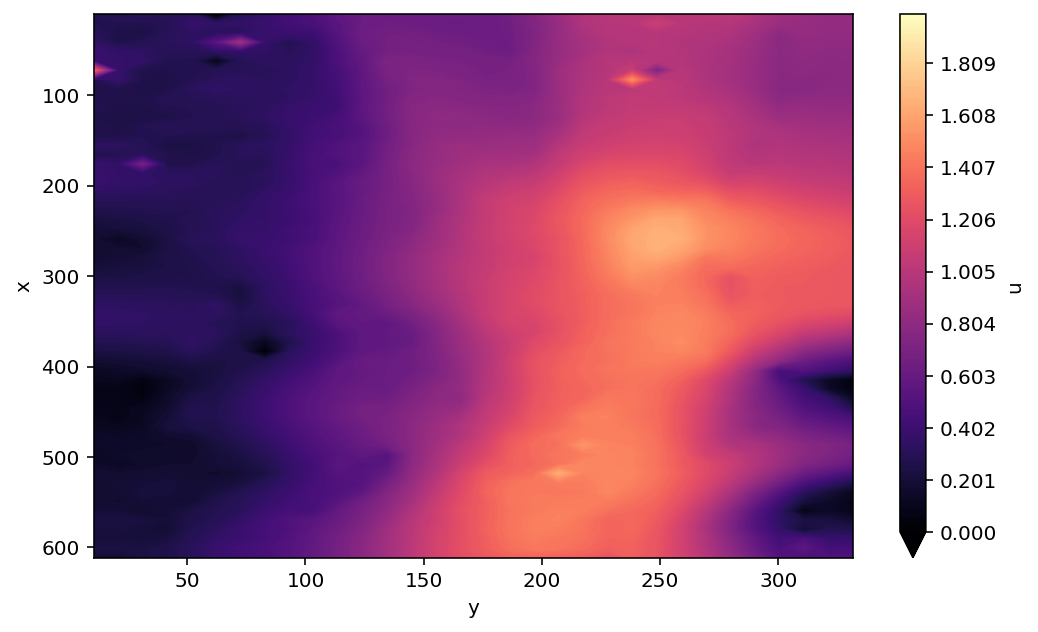

In [19]:
dfi = xr.open_dataset(pathOut)
dfi.u.mean(dim='time').plot.contourf( levels=200,yincrease=False, vmin=0, vmax=2,cmap=cm.magma, figsize=(8.5,5 ))
   
#dfu = dfi.u*-1
#dfu.mean(dim='time').transpose().plot.contourf( levels=200,yincrease=False, vmin=-1, vmax=2,cmap=cm.magma, figsize=(10,5 ))
   

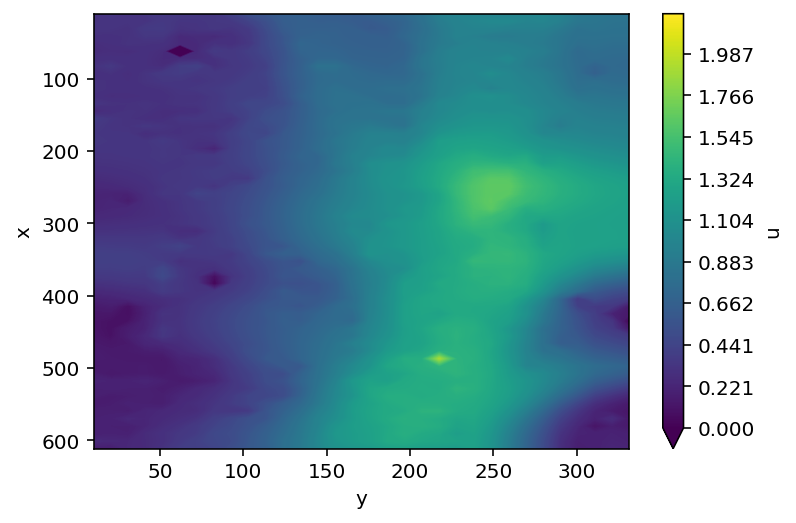

In [22]:
                                  
sel_time =np.linspace(0,10,11)

dfi_mean_s = dfi.u.sel(time = sel_time).mean(dim='time').plot.contourf(vmin=0, vmax=2.2,levels=300,yincrease=False)

In [50]:
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))


meanout = [pathOut[:-3] + '_mean.nc']
mean_output = listToString(meanout)

In [51]:
#save mean output to .nc file

dfi.u.mean(dim='time').to_netcdf(mean_output) 


# FOV =78.8     #Field of view (degrees) for mavic 4
AGL = 304.8
pathIn = '/Volumes/LaCie/Velocimetry/Night_3sec_flow.mov'
pathOut = '/Volumes/LaCie/Velocimetry/Night_3sec_flow.nc'
Vid2PIV(pathIn, pathOut , AGL, FOV)
dfr = xr.open_dataset('/Volumes/LaCie/Velocimetry/Night_3sec_flow.nc')
dfr.s.sel(time = [1]).mean(dim='time').plot.contourf( levels=200,yincrease=False, vmin=-0, vmax=3,cmap=cm.magma, figsize=(8.888,5))
#dfi.s.sel(time = sel_time).mean(dim='time').transpose().to_netcdf('/Volumes/LaCie/Velocimetry/Site6/0708/PIV_20180708_2353_TRIM_100AGL_mean.nc') # Saves on your local disk 

In [ ]:
quiver([X, Y], U, V, [C])

In [ ]:
plt.quiver([dfi.x, dfi.y], dfi.u.mean(dim='time').transpose(), dfi.v.mean(dim='time').transpose())

In [59]:
x = np.array(dfi.x, dtype=float)
y =np.array(dfi.y, dtype=float)
u = np.array(dfi.u.mean(dim='time').transpose(), dtype=float)
v = np.array(dfi.v.mean(dim='time').transpose(), dtype=float)
#plt.quiver([x,y],u,v)
v.size

1888

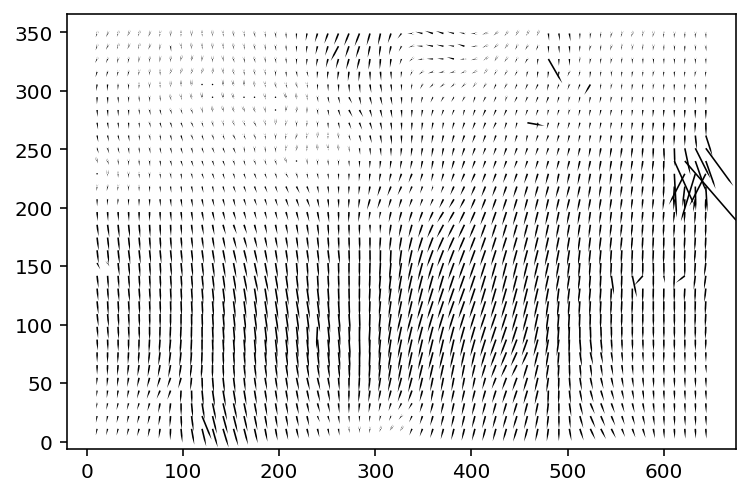

In [69]:
plt.quiver(x,y,dfi.v.mean(dim='time').transpose(),dfi.u.mean(dim='time').transpose(), headwidth=.1, scale=45, headlength=.5,)

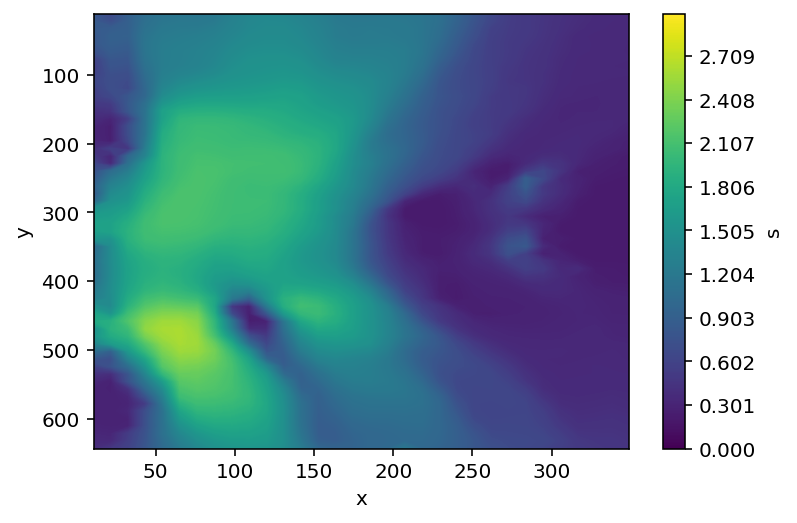

In [9]:
dfi = xr.open_dataset(pathOut)
dfi.s.mean(dim='time').transpose().plot.contourf( levels=300,yincrease=False, vmin=0, vmax=3)

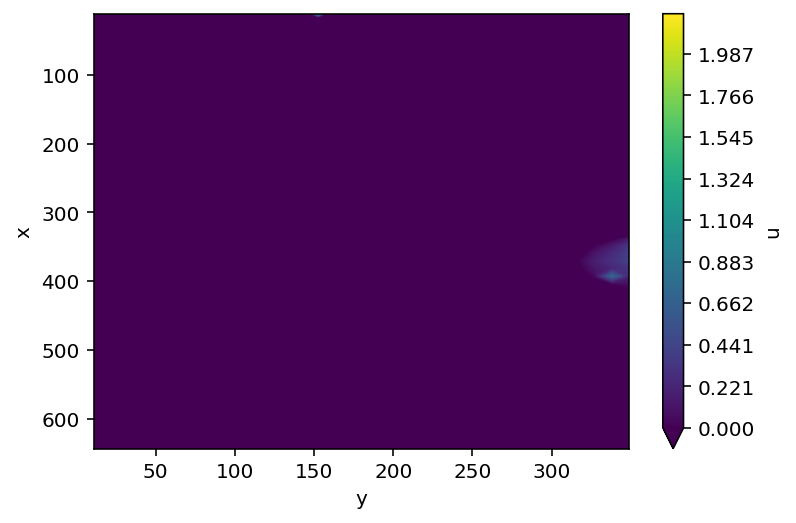

In [46]:
sel_time =np.linspace(25,35,11)

dfi_mean_s = dfi.u.sel(time = sel_time).mean(dim='time').plot.contourf(vmin=0, vmax=2.2,levels=300,yincrease=False)



In [23]:
dfi.s.sel(time = sel_time).mean(dim='time').transpose().to_netcdf('/Volumes/LaCie/Velocimetry/Site6/0714/PIV_2018_0714_1319_1500agl_mean.nc') # Saves on your local disk 

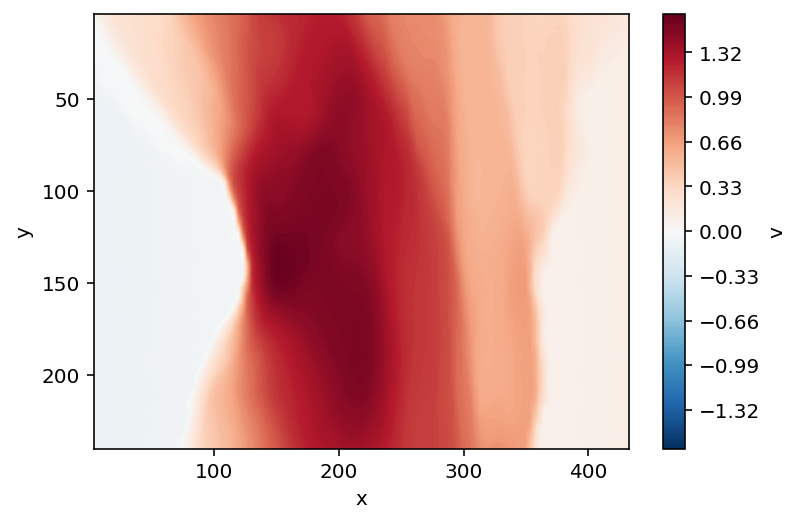

In [6]:
dfi.v.mean(dim='time').transpose().plot.contourf( levels=300,yincrease=False)

### Save as time mean

In [64]:
dfi_mean_s = dfi.s.mean(dim='time').transpose() # total speed

dfi_mean_s.to_netcdf('/Volumes/LaCie/Velocimetry/Site6/DJI_0001_20180802_VelPt6_1350_TRIM_1001agl_Vel_mean.nc') # Saves on your local disk 

In [8]:
dfx.where(dfx.s>.15).mean().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    u        float64 0.1554
    v        float64 1.304
    s        float64 1.41>

## Subtract out drone motion from velocity fields

#### Subtract out v velocity of still region from image
This may not improve result, if inital drone flight is very still, you may want to skip this step

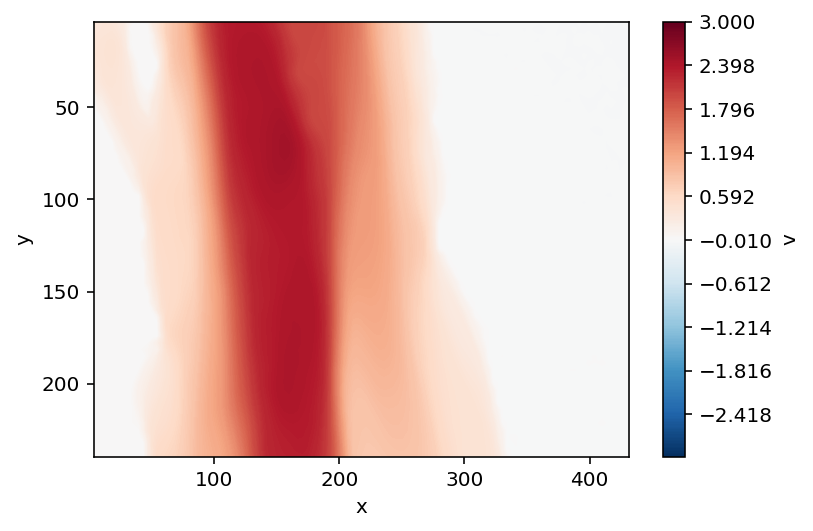

In [9]:
#Visually inspect where still regions should be
dfx.v.mean(dim='time').transpose().plot.contourf( levels=300, vmax=3, yincrease=False)

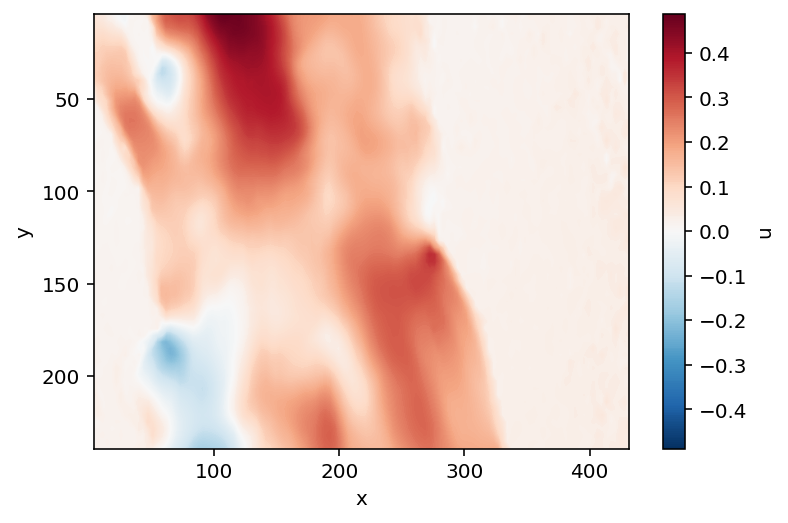

In [10]:
#Visually inspect where still regions should be
dfx.u.mean(dim='time').transpose().plot.contourf( levels=300, yincrease=False)

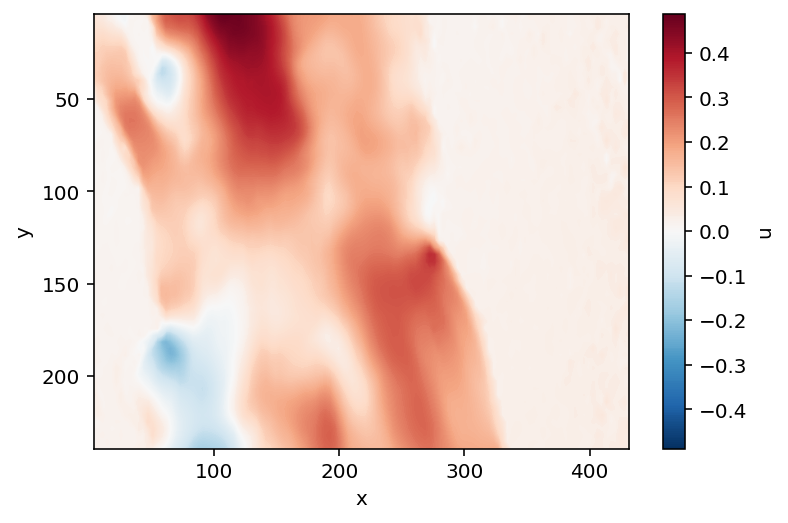

In [11]:
#Visually inspect where still regions should be
dfx.u.mean(dim='time').transpose().plot.contourf( levels=300, yincrease=False)

In [12]:
for i in range(len(dfx.time)):
    #Correct for v drone motion velocity 
    Av = dfx.sel(time= i, x=slice(350,432), y=slice(0, 237)).v.mean(dim= ('x', 'y'))
    Bv = dfx.sel(time= i, x=slice(0,25), y=slice(100, 237)).v.mean(dim= ('x', 'y'))
    Cv = (Av+Bv)/ 2
    dfx.v[i] = dfx.v[i] - Cv
    
    #correct for u drone motion velocity
    Au = dfx.sel(time= i, x=slice(350,432), y=slice(0, 237)).u.mean(dim= ('x', 'y'))
    Bu = dfx.sel( time= i, x=slice(0,25), y=slice(100, 237)).u.mean(dim= ('x', 'y'))
    Cu = (Au+Bu)/ 2
    dfx.u[i] = dfx.u[i] - Cu

    #correct for s drone motion velocity
    As = dfx.sel(time= i, x=slice(350,432), y=slice(0, 237)).s.mean(dim= ('x', 'y'))
    Bs = dfx.sel( time= i, x=slice(0,25), y=slice(100, 237)).s.mean(dim= ('x', 'y'))
    Cs = (As+Bs)/ 2
    dfx.s[i] = dfx.s[i] - Cs

In [13]:
dfx.to_netcdf('Site4_Drone_Subtract')

### Combine all Flights into one Dataset with new dimension (Flight) 
Not required for single video

In [10]:
Flights = [df07, df08, df09, df10]
dfx = xr.concat(Flights, dim = 'Flight')
dfx =dfx.sortby('Flight', ascending=True)
dfx = dfx.assign_coords(Flight =['F07','F08','F09', 'F10'])
dfx['time'] =np.arange(0,120)
dfx

<xarray.Dataset>
Dimensions:  (Flight: 4, time: 120, x: 119, y: 66)
Coordinates:
  * x        (x) float64 32.0 64.0 96.0 128.0 ... 3.744e+03 3.776e+03 3.808e+03
  * y        (y) float64 32.0 64.0 96.0 128.0 ... 2.048e+03 2.08e+03 2.112e+03
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
  * Flight   (Flight) <U3 'F07' 'F08' 'F09' 'F10'
Data variables:
    u        (Flight, time, x, y) float64 0.3826 0.4679 ... -0.5201 -0.5707
    v        (Flight, time, x, y) float64 -2.979 -3.021 ... 0.1432 -0.1152
    mask     (Flight, time, x, y) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [148]:
df0.where(df0.v<df0.v.quantile([.9999,1.00]))
#df0.u = df0.where(df0.u<df0.u.quantile([.9999,1.00]))

<xarray.Dataset>
Dimensions:   (quantile: 2, time: 1, x: 119, y: 66)
Coordinates:
  * x         (x) float64 3.629 7.258 10.89 14.52 ... 420.9 424.6 428.2 431.8
  * y         (y) float64 3.629 7.258 10.89 14.52 ... 228.6 232.2 235.9 239.5
  * time      (time) int64 0
  * quantile  (quantile) float64 0.9999 1.0
Data variables:
    u         (x, y, time, quantile) float64 0.4807 0.4807 ... 0.02616 0.02616
    v         (x, y, time, quantile) float64 -0.3472 -0.3472 ... 0.3194 0.3194
    s         (x, y, time, quantile) float64 0.593 0.593 ... 0.3204 0.3204

## Save the Xarray with all the velocity fields

In [58]:
dfx.to_netcdf('0726_Site4_Velocity_Fields.nc') # Saves on your local disk 

GSDh= flight height x sensor height / focal length x image height;
GSDw= flight height x sensor width / focal length x image width

In [14]:
vidin = '/Users/Jasper/Volc_Research/DJI_0003_20180726_1053-SA_000_002_Trim.mov'
FOV = 78.8
AGL = 304.6
Image_Width = 3840

Image_Height = 2160

In [176]:
FOV = 78
FOV = np.deg2rad(FOV) #degrees
AGL = 304.6
vidcap = cv2.VideoCapture(vidin)

Width  = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width` in pixels
Height = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height` in pixels
#Width = 6.3 
#Height = 4.7

Aspect = Height/Width    # CONFIRM THIS IS CORRECT
D =   2 * AGL *np.tan(FOV/2) #diagnol of image
A = (D) / np.sqrt(1 + Aspect**2)
B = Aspect * D / np.sqrt(1 + Aspect**2)
B = np.sqrt(D**2-A**2)
print('Image Footprint:',A, 'm x', B, 'm y')
GSDx = A/ Width #meters per pixel
GSDy = B/ Height #meters per pixel
print(GSDx,GSDy)
D

Image Footprint: 429.9660213860121 m x 241.85588702963176 m y
0.11197031806927397 0.11197031806927396


493.32043302239833

In [186]:
Og = GSDy/AGL
lin_reg = 0.0003208
Golden_ratio = lin_reg/Og
Golden_ratio

0.8726927071828547

In [190]:
GSDx2 = 0.0003225
GSDy2 = 0.0003208

#np.sqrt(GSDx2**2+GSDy2**2)

In [187]:
Og

0.0003675978925452198

In [175]:
#original Solution with rectangular pixels
FOV = 78.8
FOV = np.deg2rad(FOV) #degrees
AGL = 304.6
vidcap = cv2.VideoCapture(vidin)

WidthPix  = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width` in pixels
HeightPix = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height` in pixels
Width = 6.3 
Height = 4.7

Aspect = Height/Width    # CONFIRM THIS IS CORRECT
D =   2 * AGL *np.tan(FOV/2) #diagnol of image
A = (D) / np.sqrt(1 + Aspect**2)
B = Aspect * D / np.sqrt(1 + Aspect**2)
#B = np.sqrt(D**2-A**2)

print('Image Footprint:',A, 'm x', B, 'm y')
GSDx = A/ WidthPix #meters per pixel
GSDy = B/ HeightPix #meters per pixel
print(GSDx,GSDy)


Image Footprint: 401.0846920977226 m x 299.2219131522693 m y
0.10444913856711527 0.13852866349642096


In [162]:
FOV = 78.8
FOV = np.deg2rad(FOV) #degrees
AGL = 304.6
vidcap = cv2.VideoCapture(vidin)

WidthPix  = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width` in pixels
HeightPix = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height` in pixels
Width = 6.3 
Height = 4.7

1.3404255319148934

In [107]:
179/200

0.895

In [108]:
401.0846920977226/ 436.1385964740625

0.9196266859669582

In [49]:
pathIn = '/Volumes/KLERZ_Vel/Sites/Site5/0716/0716_0300DJI_0011_vel5_408mAGL_3sec.mov'
FOV = 78.8
AGL = 408
pathOut= '/Users/Jasper/Volc_Research/DJI_0003_20180726_1053-SA_000_002_Trim.nc'
test = Vid2PIV(pathIn,pathOut,AGL,FOV)

Number of sec in video: 2
Image Footprint: 584.1908974439182 m x 328.607379812204 m y
Read a new frame 001 True


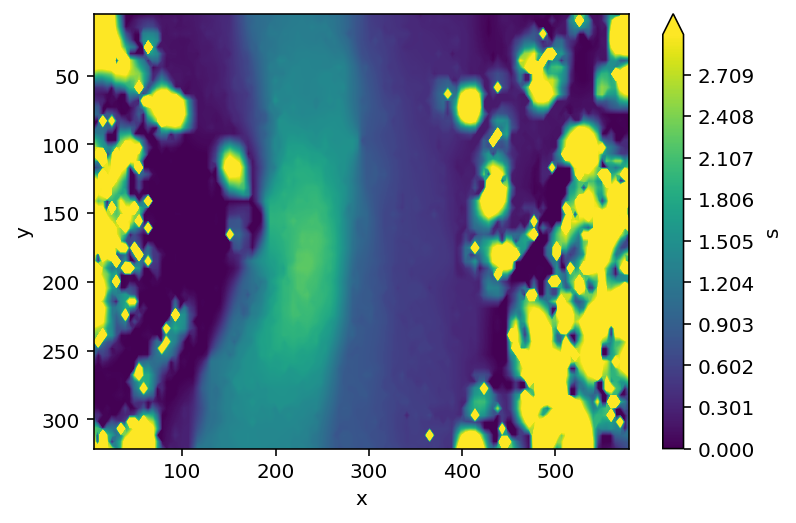

In [50]:
test.s.mean(dim='time').transpose().plot.contourf( levels=300, vmax=3, yincrease=False)

GSD=[Sensor width (mm) x h (m)]/ [(focal length (mm) x Sensor width (px)]

In [98]:
Swidth = 6.3   #13.2 #mm
Sheight =  4.7 #8.8  #mm
FOVmm = 26 #mm
AGL = 304.8

GSDw = (Swidth* AGL)/ (FOVmm * Width)
GSDw * Width
#GSD * Height

GSDh = (Sheight* AGL)/ (FOVmm * Height)

GSDw *1e-2 *Width, GSDh*1e-2*Height
Height

2160.0

In [125]:
def Vid2PIV2(fileIn, fileOut, AGL, FOV, Swidth, Sheight):
    
    """ Vid2PIV is a function used to convert still hovering drone footage to scaled velocity fields which can be analyzed in xarray. 
    It is an implementation of particle image velocimetry based on OpenPIV.
    
    INPUTS: 
   
    fileIn: Local path to video (.mov or .mp4 file format)
    fileOut: Name you would like to save your velocity .nc file
    AGL: Above ground level (Altitude of drone) in meters
    FOV: Field of View of sensor in degrees
    
    OUTPUTS: A saved xarray dataset in .nc file format
    
    """
    
    
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success, frame_a = vidcap.read()
    

    
    tf =  int(np.floor(vidcap.get(cv2.CAP_PROP_FRAME_COUNT)/ vidcap.get(cv2.CAP_PROP_FPS))) #to get number of seconds in video final time
    print('Number of sec in video:', tf)
    x, y = process.get_coordinates( image_size=frame_a.shape, window_size=64, overlap=32 )
    
    
    dfi = xr.Dataset(
        data_vars={'u': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1))),
                   'v': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1))),
                   's': (('x', 'y', 'time'), np.zeros((len(x[0,:]),len(y[:,0]),tf-1)))},
        coords={'x': x[0,:],'y': y[:,0],'time':np.arange(tf-1)})
    
    
    frame_a = frame_a[:,:,2]*0.2989 + frame_a[:,:,1]*0.5870 + 0.1140*frame_a[:,:,0] #convert to greyscle
    frame_a = (frame_a).astype(np.int32)
    
    
    #Calulate GSD for video
    FOV = np.deg2rad(FOV) #degrees
    WidthPix  = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width` in pixels
    HeightPix = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height` in pixels
    #GSDw = (Swidth* AGL *100)/ (FOVmm * Width)
    #GSDh = (Sheight* AGL *100)/ (FOVmm * Height) #meters per pixel

    Width = Swidth #6.3 
    Height = Sheight #4.7

    Aspect = Height/Width    # CONFIRM THIS IS CORRECT
    D =   2 * AGL *np.tan(FOV/2) #diagnol of image
    A = (D) / np.sqrt(1 + Aspect**2)
    B = Aspect * D / np.sqrt(1 + Aspect**2)
    B = np.sqrt(D**2-A**2)
    print('Image Footprint:',A, 'm x', B, 'm y')
    GSDx = A/ WidthPix #meters per pixel
    GSDy = B/ HeightPix #meters per pixel
    print(GSDx,GSDy)
    
    
    
    for count in np.arange(tf-1):
        
        vidcap.set(cv2.CAP_PROP_POS_MSEC,((count+1)*1000))    # added this line (1000 is 1 second, 100 is .1 sec) 
        success,frame_b = vidcap.read()
        print ('Read a new frame', "%03d" % (count+1), success)  #take it out
      
      #PIV
               
        frame_b = frame_b[:,:,2]*0.2989 + frame_b[:,:,1]*0.5870 + 0.1140*frame_b[:,:,0]
        frame_b = (frame_b).astype(np.int32)
       

        u, v, sig2noise = process.extended_search_area_piv( frame_a, frame_b, \
            window_size=64, overlap=32, dt=1, search_area_size=128, sig2noise_method='peak2peak' )
        #x, y = process.get_coordinates( image_size=frame_a.shape, window_size=64, overlap=32 )
        u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.2 ) #why does it not work at night?
        u, v, mask = validation.global_val( u, v, (-1000, 2000), (-1000, 1000) )
        u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
        #x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1)
    
        
        dfi.u[:,:,count] = np.transpose(u)
        dfi.v[:,:,count] = np.transpose(v)
    
    
    # additional processing
    #Sensor and Drone Measurments 
        dfi.u[:,:,count] = dfi.u[:,:,count] *GSDx 
        dfi.v[:,:,count] = dfi.v[:,:,count]*-1 * GSDy # the negative is to make the downstream velocity positive
        dfi.s[:,:,count] = np.sqrt(dfi.u[:,:,count]**2+dfi.v[:,:,count]**2) 
        

        
        frame_a = frame_b
    
    #Spatial Calculation (can possibly take this out of the loop?)
    dfi['x'] = dfi.x*GSDx 
    dfi['y']= dfi.y*GSDy 
    
    dfi.to_netcdf(pathOut)
    
    return(dfi)

In [126]:
np.tan(FOV/2)


-7.643464844425448

Number of sec in video: 2
Image Footprint: 400.42631276072706 m x 298.7307412659392 m y
0.10427768561477267 0.13830126910460147
Read a new frame 001 True


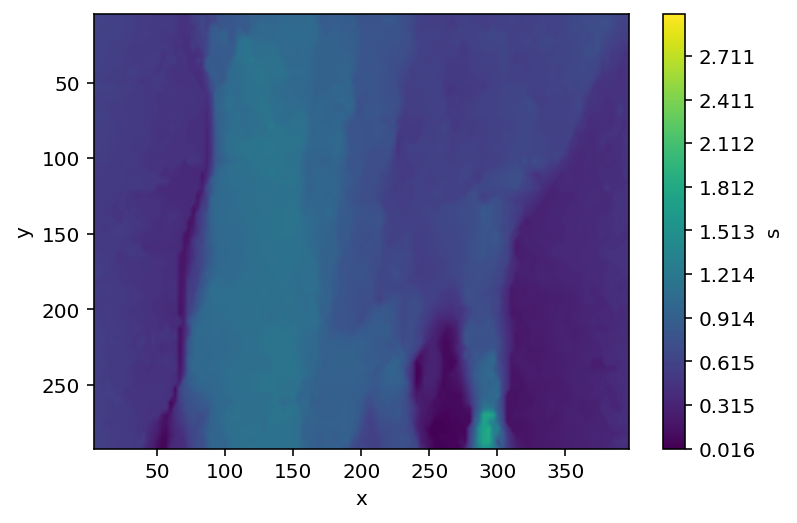

In [127]:
pathIn = '/Users/Jasper/Volc_Research/Workflow_OPENPIV/Local_Drive_Workflow/Site6_2sec.mov'

Swidth =  6.3  #13.2 #*1e-3  #mm
Sheight = 4.7 #  8.8#*1e-3  #mm
FOV =  78.8  #26 #*1e3 #m #mm
AGL = 304.1 #m
pathOut= '/Volumes/LaCie/LAVA-USB/KLERZ/KLERZ_FirstAttempts/Videos/Site6_2sec_NewCalc_sens.nc'
test2 = Vid2PIV2(pathIn,pathOut,AGL,FOV,Swidth,Sheight )

test2.s.mean(dim='time').transpose().plot.contourf( levels=300, vmax=3, yincrease=False)

In [135]:
6*(HeightPix /WidthPix)

3.375

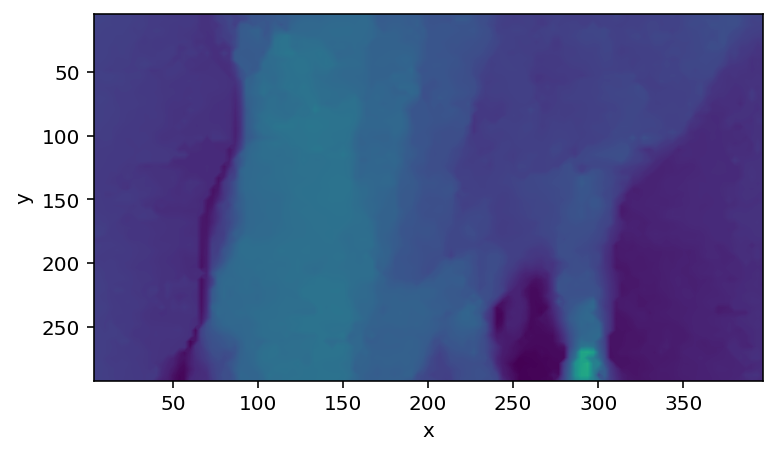

In [137]:
test2.s.mean(dim='time').transpose().plot.contourf( levels=300, vmax=3, yincrease=False, figsize =(6,3.375), add_colorbar=False )

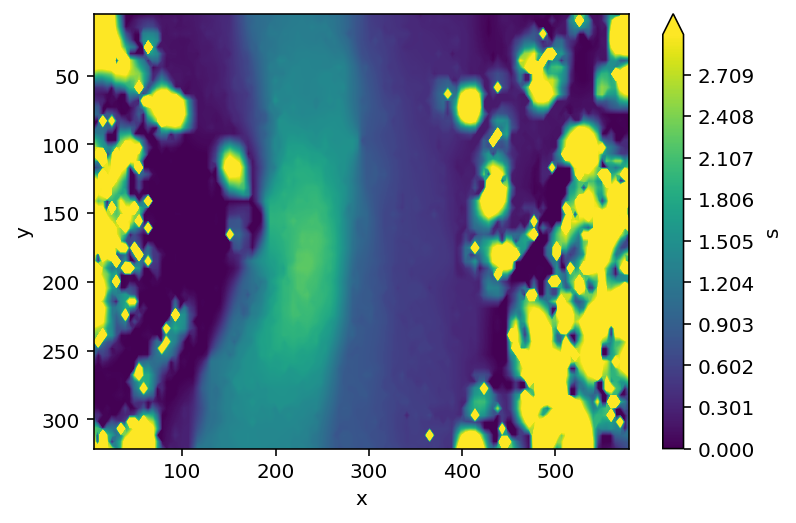

In [54]:
test.s.mean(dim='time').transpose().plot.contourf( levels=300, vmax=3, yincrease=False)

Number of sec in video: 2
Image Footprint: 435.42267625660674 m x 244.9252553943413 m y
Read a new frame 001 True


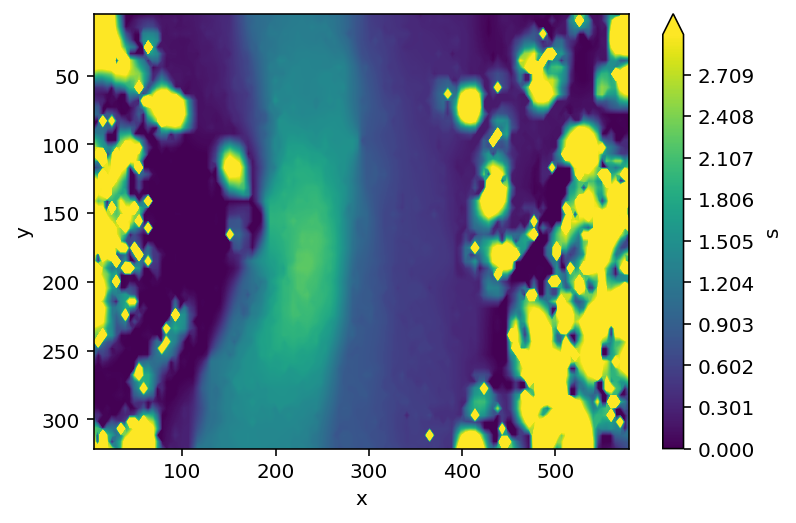

In [115]:
pathIn = '/Users/Jasper/Volc_Research/Workflow_OPENPIV/Local_Drive_Workflow/Site6_2sec.mov'
FOV = 78.8
AGL = 304.1
pathOut= '/Users/Jasper/Volc_Research/Workflow_OPENPIV/Local_Drive_Workflow/Site6_GSD_Test/Site6_2sec_Original.nc'
test0 = Vid2PIV(pathIn, pathOut, AGL, FOV)
test.s.mean(dim='time').transpose().plot.contourf( levels=300, vmax=3, yincrease=False, colorbar = False)

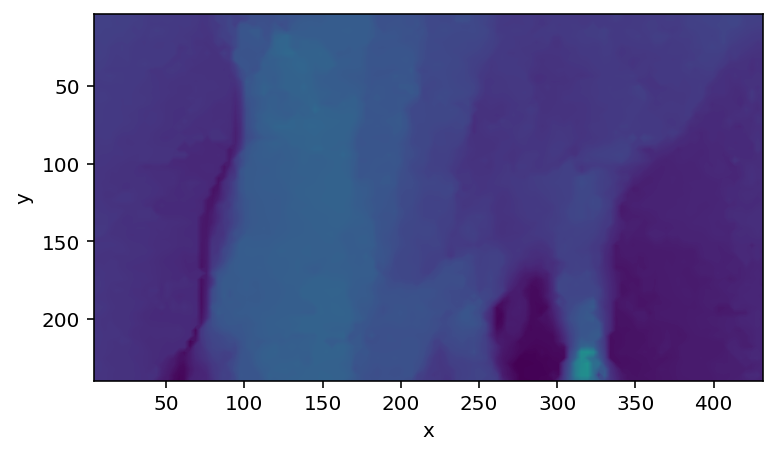

In [141]:
test0.s.mean(dim='time').transpose().plot.contourf( levels=300, vmax=3, yincrease=False, figsize =(6,3.375), add_colorbar = False)

In [154]:
antiGSD = (test0.x[1] -test0.x[0])/32
test0.x / antiGSD
test0.y / antiGSD

<xarray.DataArray (y: 66)>
array([  32.,   64.,   96.,  128.,  160.,  192.,  224.,  256.,  288.,
        320.,  352.,  384.,  416.,  448.,  480.,  512.,  544.,  576.,
        608.,  640.,  672.,  704.,  736.,  768.,  800.,  832.,  864.,
        896.,  928.,  960.,  992., 1024., 1056., 1088., 1120., 1152.,
       1184., 1216., 1248., 1280., 1312., 1344., 1376., 1408., 1440.,
       1472., 1504., 1536., 1568., 1600., 1632., 1664., 1696., 1728.,
       1760., 1792., 1824., 1856., 1888., 1920., 1952., 1984., 2016.,
       2048., 2080., 2112.])
Coordinates:
  * y        (y) float64 3.629 7.257 10.89 14.51 ... 228.6 232.2 235.9 239.5

In [161]:
antiGSD
# GSD = 

<xarray.DataArray 'x' ()>
array(0.11339132)

In [159]:
pixtest0s = (test0.s /antiGSD)

In [ ]:
(test0.u /antiGSD) * (test0.v /antiGSD)